# Comparison between ALG_001_EXP_001 and ALG_002_EXP_001 results
For further details, please visit:
<ul>
    <li><a href="./ALG_001-EXP_001-Baseline.ipynb">ALG_001_EXP_001</a></li>
    <li><a href="./ALG_002_EXP_001-Baseline-MacLean_et_al.ipynb">ALG_002_EXP_001</a></li>
</ul> 

### Loading used modules

In [1]:
###################################################################
# Built-in modules ################################################
###################################################################
import sys
import os
sys.path.append(os.path.join("..", ".."))

import numpy as np
import imp
import cv2
import matplotlib.pyplot as plt
import gc
from components.utils.CSVWriter2 import Wrapper as l
from components.utils.Metrix import Wrapper as me
import math
import time
import glob
import pandas as pd
import ipywidgets as widgets

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.OriginalMatcher3 import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv
from components.utils import visualisation_utils as vu

###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu
import project_helpers



In [2]:
dropdown_interactivity = widgets.Dropdown(
                                            options = [("static", "inline"), ("interactive", "notebook")],
    description = "Interactivity:"
)
print("Please, if you experience rendering problems, switch to static rendering.")
dropdown_interactivity

Please, if you experience rendering problems, switch to static rendering.


Dropdown(description='Interactivity:', options=(('static', 'inline'), ('interactive', 'notebook')), value='inl…

In [3]:
interactivity = dropdown_interactivity.value
interactivity

'inline'

### Experiment and dataset paths

In [4]:
ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_002_EXP_001-Baseline-MacLean_et_al"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")


SCENES = ["teddy", "cones"]
SIZE=""
YEAR= 2003


CSV_FILE_2 = "ALG_001-EXP_001-Baseline.csv"

CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
CSV_FILEPATH_2 = os.path.join(LOG_FOLDER, CSV_FILE_2)

###  Loading the dataset and its visualisation

..\..\datasets\middlebury\middlebury_2003\teddy
..\..\datasets\middlebury\middlebury_2003\teddy\im2.png
..\..\datasets\middlebury\middlebury_2003\teddy\im6.png
..\..\datasets\middlebury\middlebury_2003\teddy\disp2.png
..\..\datasets\middlebury\middlebury_2003\teddy\nonocc.png
..\..\datasets\middlebury\middlebury_2003\cones
..\..\datasets\middlebury\middlebury_2003\cones\im2.png
..\..\datasets\middlebury\middlebury_2003\cones\im6.png
..\..\datasets\middlebury\middlebury_2003\cones\disp2.png
..\..\datasets\middlebury\middlebury_2003\cones\nonocc.png


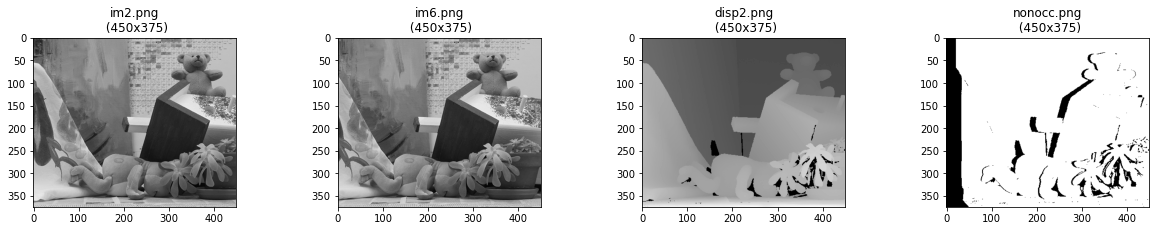

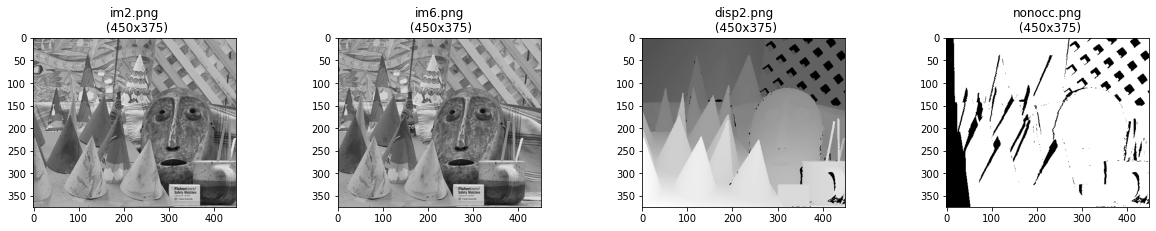

In [5]:
%matplotlib $interactivity
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene) for scene in SCENES)
nonocc_gts = list()
i =1
for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)
    temp = mbu.add_masks_to_raw_disparity(im[2], im[3])
    nonocc_gts.append(temp)


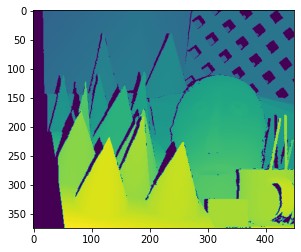

In [6]:
plt.imshow(nonocc_gts[1])

### Loading the logs
Do we have a matching number of log entries?

In [7]:
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="bad4", inplace=True) 
experiment_log.drop_duplicates(inplace=True)


experiment_log_2 = pd.read_csv(CSV_FILEPATH_2)
experiment_log_2.drop_duplicates(inplace=True)
experiment_log_2 = experiment_log_2[experiment_log_2["init_method"]=="gap*col_index"]

experiment_log_2.shape == experiment_log.shape

True

### Merging the log files

In [8]:
joined_log = experiment_log.merge(experiment_log_2, on=["match", "gap", "egap", "scene", "are_occlusions_errors"])
joined_log.columns

Index(['experiment_id_x', 'match', 'gap', 'egap', 'algo_x', 'init_method_x',
       'dataset_x', 'scene', 'image_filename_x', 'img_res_x',
       'preprocessing_method_x', 'kernel_size_x', 'kernel_spec_x',
       'are_occlusions_errors', 'abs_error_x', 'mse_x', 'avg_x', 'eucledian_x',
       'bad1_x', 'bad2_x', 'bad4_x', 'bad8_x', 'runtime_x', 'experiment_id_y',
       'algo_y', 'init_method_y', 'dataset_y', 'image_filename_y', 'img_res_y',
       'preprocessing_method_y', 'kernel_size_y', 'kernel_spec_y',
       'abs_error_y', 'mse_y', 'avg_y', 'eucledian_y', 'bad1_y', 'bad2_y',
       'bad4_y', 'bad8_y', 'runtime_y'],
      dtype='object')

### Comparing the two log files' results
The "Maclean_et_al" version fares better in both regards.

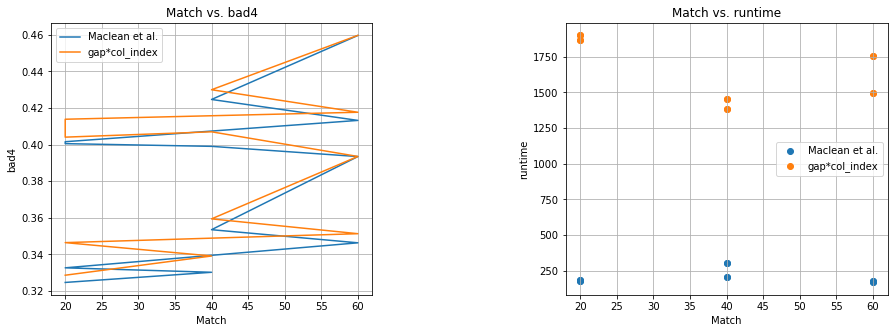

In [9]:
%matplotlib $interactivity
x1 = joined_log["match"].values
y1 = joined_log["bad4_x"].values
x2 = joined_log["match"].values
y2 = joined_log["bad4_y"].values

fig = plt.figure(figsize=[15, 5])
fig.subplots_adjust(wspace=0.6)

ax = fig.add_subplot(1,2,1)
ax.plot(x1, y1, label="Maclean et al.")
ax.plot(x2,y2, label="gap*col_index")
ax.set_xlabel("Match")
ax.set_ylabel("bad4")
ax.legend()
ax.set_title("Match vs. bad4")
ax.grid()


y1 = joined_log["runtime_x"].values
y2 = joined_log["runtime_y"].values

ax = fig.add_subplot(1,2,2)
ax.scatter(x1, y1, label="Maclean et al.")
ax.scatter(x2,y2, label="gap*col_index")
ax.set_xlabel("Match")
ax.set_ylabel("runtime")
ax.legend()
ax.set_title("Match vs. runtime")
ax.grid()


### Loading image data to dataframes for visual analysis

In [10]:
read_function = lambda p: plt.imread(project_helpers.fix_win_rel_paths(p))

joined_log["loaded_imgs_x"] = [read_function(img_path) for img_path in joined_log["image_filename_x"]]

joined_log["loaded_imgs_y"] = [read_function(img_path) for img_path in joined_log["image_filename_y"]]

joined_log["loaded_imgs_x_titles"] =  joined_log["scene"].values+"_"+\
                                      joined_log["init_method_x"].values+"_"+\
                                      joined_log["match"].astype(str).values
        
joined_log["loaded_imgs_y_titles"] =  joined_log["scene"].values+"_"+\
                                      joined_log["init_method_y"].values+"_"+\
                                      joined_log["match"].astype(str).values


## Visualisations

In [11]:
dropdown = widgets.Dropdown(
    options=[("ALG_002_EXP_001", "x"), ("ALG_001_EXP_001", "y")],
    description='Experiment:',
    disabled=False,
)
dropdown

Dropdown(description='Experiment:', options=(('ALG_002_EXP_001', 'x'), ('ALG_001_EXP_001', 'y')), value='x')

In [12]:
selected_experiment_suffix = dropdown.value

results = joined_log["loaded_imgs_"+selected_experiment_suffix].values

titles = joined_log["loaded_imgs_"+selected_experiment_suffix+"_titles"]


### Disparity estimates

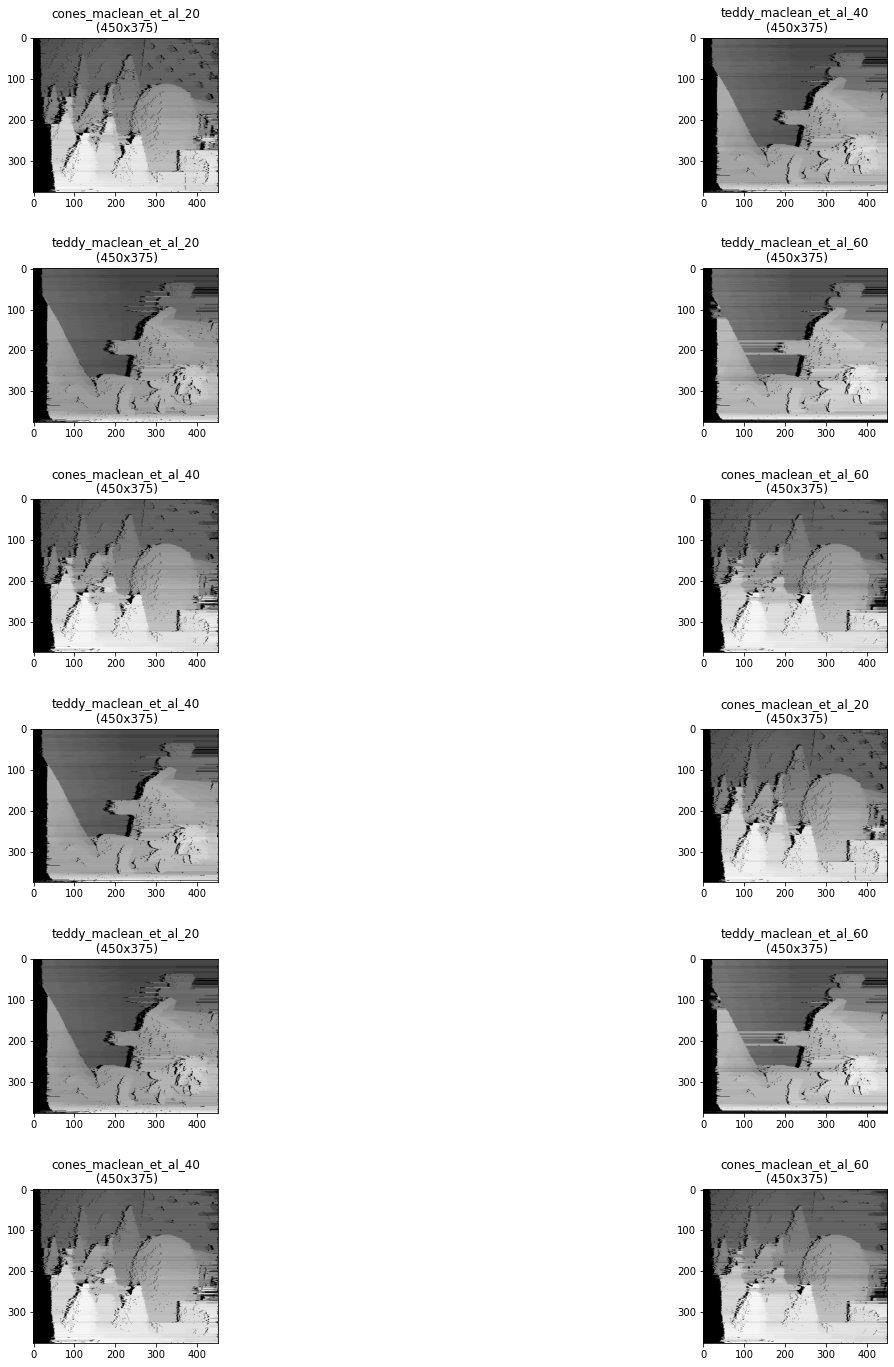

In [13]:
%matplotlib $interactivity
plu.plot_images(results, titles, ncols=2)

### Comparing output disparities with the ground truth: histograms
Note: Disparity estimates are compared to masked ground truths.

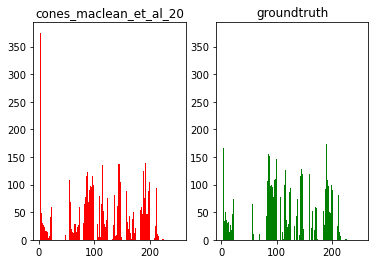

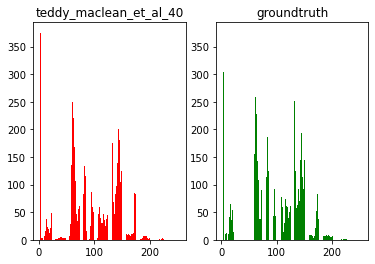

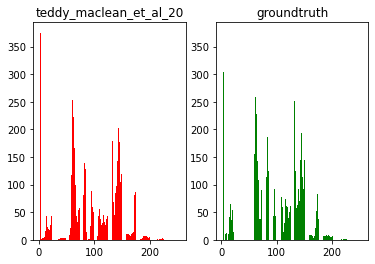

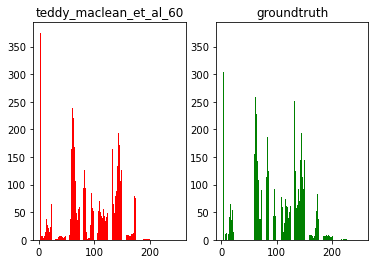

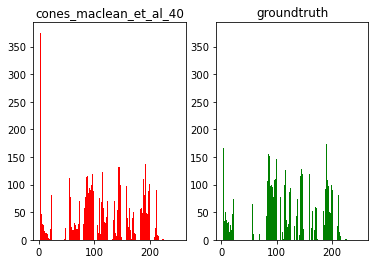

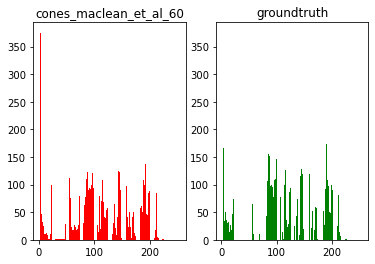

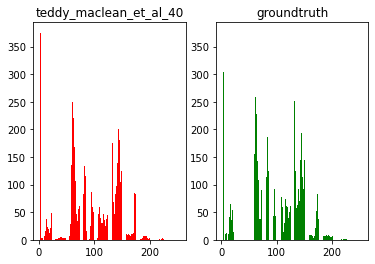

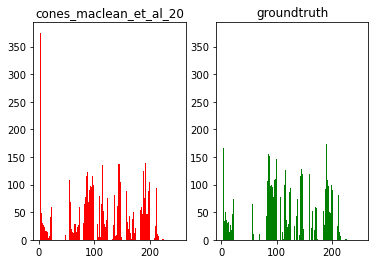

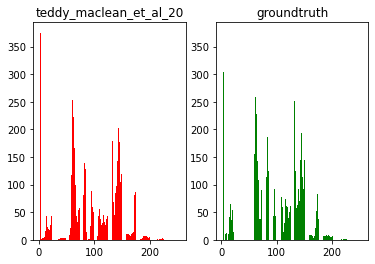

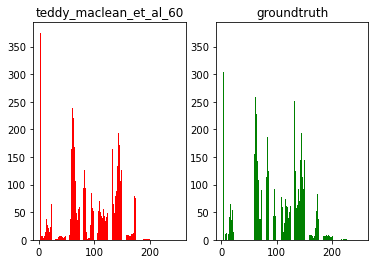

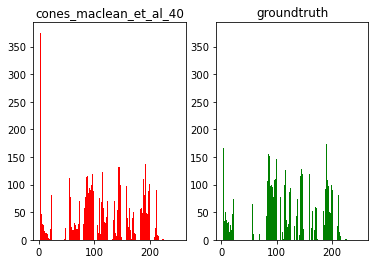

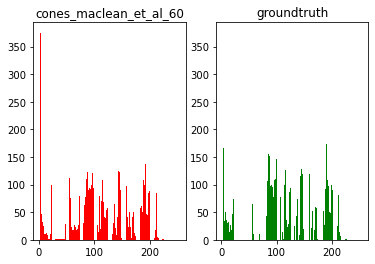

In [14]:
%matplotlib $interactivity

counter = 0
for img, title in zip(results, titles):
    nonocc_index = 0 if "teddy" in title else 1
    vu.compare_histograms(img*255, nonocc_gts[nonocc_index], titles = [title, "groundtruth"])
    counter+=1

### Comparing output disparities with the ground truth: "hit and miss"

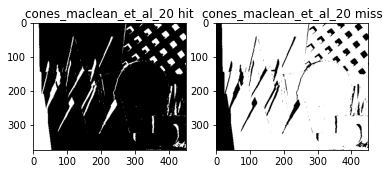

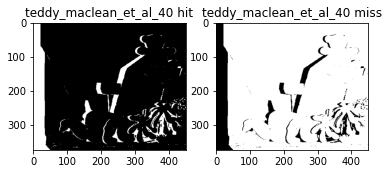

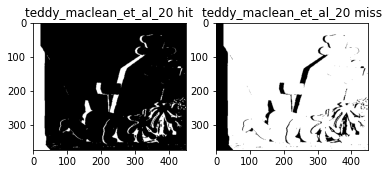

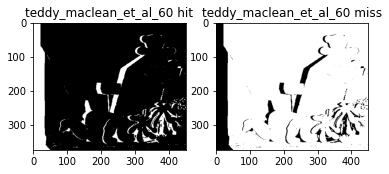

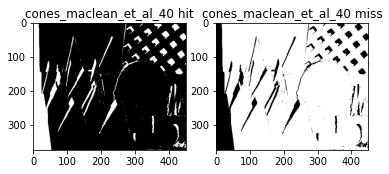

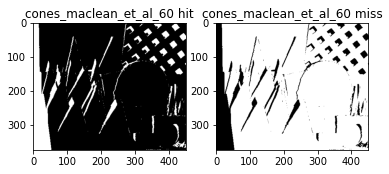

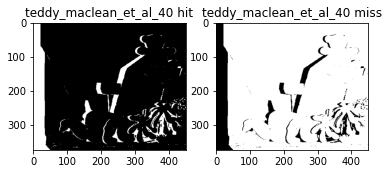

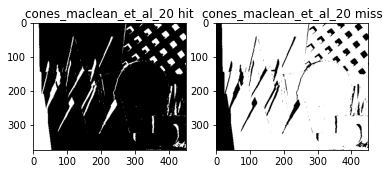

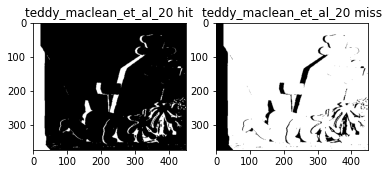

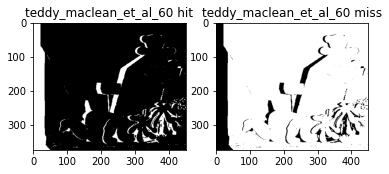

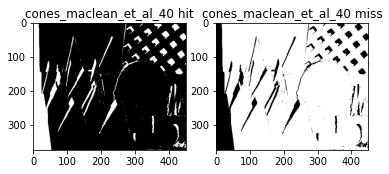

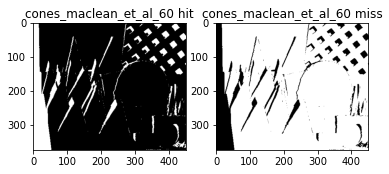

In [15]:
%matplotlib $interactivity
for img, title in zip(results, titles):
    #print(int((i)%2))
    nonocc_index = 0 if "teddy" in title else 1
    vu.show_hit_and_miss(img, nonocc_gts[nonocc_index], threshold=4, titles=[title+" hit", title+" miss"])

# Needs revision and fixing from here
### Comparing output disparities with the ground truth: differences shown in 3D

In [16]:
dropdown_image_selector = widgets.Dropdown(
    options = [(title, i) for i, title in enumerate(titles)],
    description = "Image"
)
dropdown_image_selector

Dropdown(description='Image', options=(('cones_maclean_et_al_20', 0), ('teddy_maclean_et_al_40', 1), ('teddy_m…

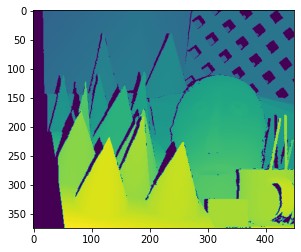

In [17]:
plt.imshow(nonocc_gts[nonocc_index])

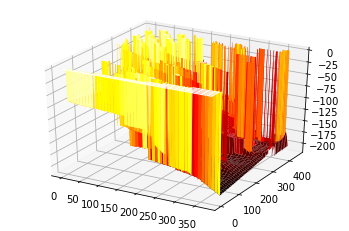

In [18]:
%matplotlib $interactivity
image_index = dropdown_image_selector.value
nonocc_index = 0 if "teddy" in titles[image_index] else 1
vu.show_difference(results[image_index], nonocc_gts[nonocc_index], cmm="hot")

### Loading dataset in color mode

In [19]:
loaded_imgs_and_paths_colored = list(mbu.get_images(DATASET_FOLDER, YEAR, scene, grayscale=False) for scene in SCENES)

..\..\datasets\middlebury\middlebury_2003\teddy
..\..\datasets\middlebury\middlebury_2003\teddy\im2.png
..\..\datasets\middlebury\middlebury_2003\teddy\im6.png
..\..\datasets\middlebury\middlebury_2003\teddy\disp2.png
..\..\datasets\middlebury\middlebury_2003\teddy\nonocc.png
..\..\datasets\middlebury\middlebury_2003\cones
..\..\datasets\middlebury\middlebury_2003\cones\im2.png
..\..\datasets\middlebury\middlebury_2003\cones\im6.png
..\..\datasets\middlebury\middlebury_2003\cones\disp2.png
..\..\datasets\middlebury\middlebury_2003\cones\nonocc.png


### Displaying the ground truth disparity with the left image as its surface
The "finess" parameter is responsible for the smoothness of rendering. The less, the more accurate it is. Matplotlib is sensitive to this parameter when it comes to interactive charts and 3D rendering, therefore the recommended minimum level is 5.

In [20]:
dropdown_scene = widgets.Dropdown(
    options=[("teddy", 0), ("cones", 1)],
    description='Scene:',
    disabled=False,
)
options = [i for i in range(1, 30)]
slider = widgets.SelectionSlider(
    options=options,
    value=5,
    description='Quality:',
    disabled=False
)

widgets.VBox([dropdown_scene, slider])

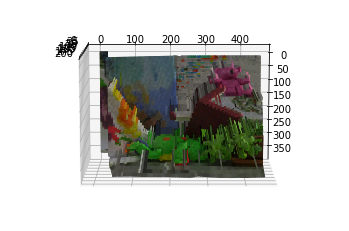

In [21]:
%matplotlib $interactivity
vu.plod3d_with_img_surface(nonocc_gts[dropdown_scene.value], finess=slider.value, surface=loaded_imgs_and_paths_colored[dropdown_scene.value][0][0])

### Displaying a disparity and the back-projection of the image to its surface in 3D
Note: errors (bad4) are shown in black <br>
    

In [22]:
options = [i for i in range(1, 30)]
slider_quality = widgets.SelectionSlider(
    options=options,
    value=5,
    description='Quality:',
    disabled=False
)
options2 = [i for i in range(1, 10)]
slider_bad = widgets.SelectionSlider(
    options=options,
    value=4,
    description='Bad:',
    disabled=False
)
dropdown_image_selector_2 = widgets.Dropdown(
    options = [(title, i) for i, title in enumerate(titles)],
    description = "Image"
)
dropdown_image_selector
widgets.VBox([dropdown_image_selector_2,slider_bad,  slider_quality])

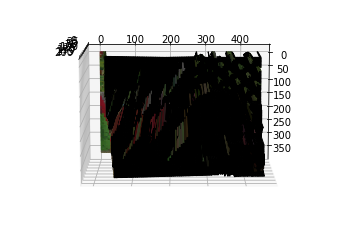

In [23]:
### Array indices:
%matplotlib inline
image_index = dropdown_image_selector_2.value
nonocc_index = 0 if "teddy" in titles[image_index] else 1

selected_disparity = results[image_index]
hit_mask = np.abs(results[image_index]-nonocc_gts[nonocc_index])>slider_bad.value

img_to_modify = loaded_imgs_and_paths_colored[nonocc_index][0][0].copy()
img_to_modify[hit_mask, :]=0
vu.plod3d_with_img_surface(nonocc_gts[nonocc_index], finess=slider_quality.value, surface=img_to_modify)
